# Import libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

# Coordinates transformation

In [11]:
# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = [994.2, 947.4,-267.4,-261.5,]

# Z coordinates translations
local_z_shifts = [z*ZCELL for z in range(0,4)]
global_z_shifts = [823.5, 0, 823.5, 0]

# Open file

This code opens 1 files, reads line by line and returns a list of floats for each line.

In [12]:
'''data_file = "../data/calibration/Run000260/data_000000.txt"
with open(data_file) as f:
    for line in f:
        event = line.split()
        event = [float(i) for i in event]
        print(event)'''

'data_file = "../data/calibration/Run000260/data_000000.txt"\nwith open(data_file) as f:\n    for line in f:\n        event = line.split()\n        event = [float(i) for i in event]\n        print(event)'

Let's just use 1 line, in order to test the code.

In [13]:
data_file = "../data/calibration/Run000260/data_000000.txt"
with open(data_file) as f:
    line = f.readline()
    line = f.readline()
    line = f.readline()
    line = f.readline()
    #line = f.readline()
    event = line.split()
    #event = [float(i) for i in event]
    print(event)

['4', '12', '0', '1', '6.501e+02', '6.519e+02', '15.8', '2', '2', '1.658e+02', '1.702e+02', '41.7', '2', '4', '1.606e+02', '1.754e+02', '137.5', '2', '1', '1.277e+02', '1.663e+02', '359.2', '2', '3', '1.318e+02', '1.622e+02', '282.5', '3', '2', '4.056e+01', '4.344e+01', '26.7', '3', '1', '1.395e+01', '2.805e+01', '130.8', '3', '4', '3.531e+01', '4.869e+01', '124.2', '3', '3', '1.853e+01', '2.347e+01', '45.8', '3', '2', '2.594e+01', '5.806e+01', '298.3', '3', '3', '2.871e+00', '3.913e+01', '336.7', '3', '1', '4.824e+01', '7.776e+01', '274.2']


# Read data

- **Input**: 1 row of data_file.txt, e.g. 1 event, passed as a `list`
- **Output**: pandas dataframe as in the *Data Format* paragraph, Number of the Event, Number of hits in the Event

This function takes in input one event at time, and then outputs a pandas dataframe as described in the previous section. In addition, the transformation from local to global coordinates is performed.

In [14]:
def read_data(event):    
    event_number = int(event[0])
    hits_number  = int(event[1])
    hit       = np.arange(hits_number)
    chamber   = np.fromiter((event[2+5*i] for i in range(hits_number)), int)
    layer     = np.fromiter((event[3+5*i] for i in range(hits_number)), int)
    xl_local  = np.fromiter((event[4+5*i] for i in range(hits_number)), float)
    xr_local  = np.fromiter((event[5+5*i] for i in range(hits_number)), float)
    z_local   = np.fromiter((local_z_shifts[i-1]+ZCELL/2 for i in layer), float)
    time      = np.fromiter((event[6+5*i] for i in range(hits_number)), float)
    xl_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xl_local
    xr_global = np.fromiter((global_x_shifts[i] for i in chamber), float) - xr_local
    z_global  = np.fromiter((global_z_shifts[i] for i in chamber), float) + z_local
    dataframe = pd.DataFrame(
        { 'EvNumber' : event_number,
          'Hit'      : hit,
          'Chamber'  : chamber,
          'Layer'    : layer,
          'XL_local' : xl_local,
          'XR_local' : xr_local,
          'Z_local'  : z_local,
          'Time'     : time,
          'XL_global': xl_global,
          'XR_global': xr_global,
          'Z_global' : z_global,
        })
    #dataframe.set_index('Hit', inplace=True) # set as index the number of the hit 
    return dataframe, event_number, hits_number

ev, evNumber, hits = read_data(event)
ev["EvNumber"][0]

4

# Plot background

- **Input**: `None`
- **Output**: `list`\[pyplot `Axes`\] (global image + 4 detectors zooms)

The input of the function is the pandas dataframe made by the *Read Data* function. Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

Instead of having 4 different 2D numpy arrays with the coordinates of the vertices of the 4 chambers, we create a pandas DataFrame with the following columns:

| chamber | x_vertices | y_vertices |
| --- | --- | --- |

where *x_vertices*, *y_vertices* contain a list with the four x/y coordinates of the 4 vertices of the chamber.

In [15]:
def plot_background():
    # create Pandas DataFrame for the cambers positions
    chamber_position = pd.DataFrame({
    'chamber' : [i for i in range(4)],
    'x_vertices' : [(global_x_shifts[i], global_x_shifts[i] - 720, global_x_shifts[i] - 720, global_x_shifts[i])
                    for i in range(4)],
    'y_vertices' : [(global_z_shifts[i], global_z_shifts[i], global_z_shifts[i] + 52, global_z_shifts[i] + 52)
                    for i in range(4)],
    })
    x_lim = [[-1000, 1000], # global detector
             [    0, 1000], # chamber 0
             [    0, 1000], # chamber 1
             [-1000,    0], # chamber 2
             [-1000,    0]] # chamber 3
    y_lim = [[-100, 1000],  # global detector
             [800 ,  900],  # chamber 0
             [ -25,   75],  # chamber 1
             [ 800,  900],  # chamber 2
             [ -25,   75]]  # chamber 3
    title = ["DETECTOR", "Chamber 0", "Chamber 1", "Chamber 2", "Chamber 3"]
    # create pyplot 'Axes' objects
    ax_global = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax_0 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=1) # top-right
    ax_1 = plt.subplot2grid(gridsize, (3, 1), colspan=1, rowspan=1) # bottom-right
    ax_2 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=1) # top-left
    ax_3 = plt.subplot2grid(gridsize, (3, 0), colspan=1, rowspan=1) # bottom-left
    
    axes = [ax_global, ax_0, ax_1, ax_2, ax_3]
    for index, ax in enumerate(axes):
        ax.set_xlim(x_lim[index])
        ax.set_ylim(y_lim[index])
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("z [mm]")
        if index == 0: ax.set_title(title[index])
        else: ax.set_title(title[index], pad=-20)
        # plot the 4 chambers in each 'Axes'
        for j in range(4):
            chamber = chamber_position[chamber_position["chamber"] == j]
            ax.fill(chamber["x_vertices"].values[0], chamber["y_vertices"].values[0], color='gray', fill=False)
    return axes
    

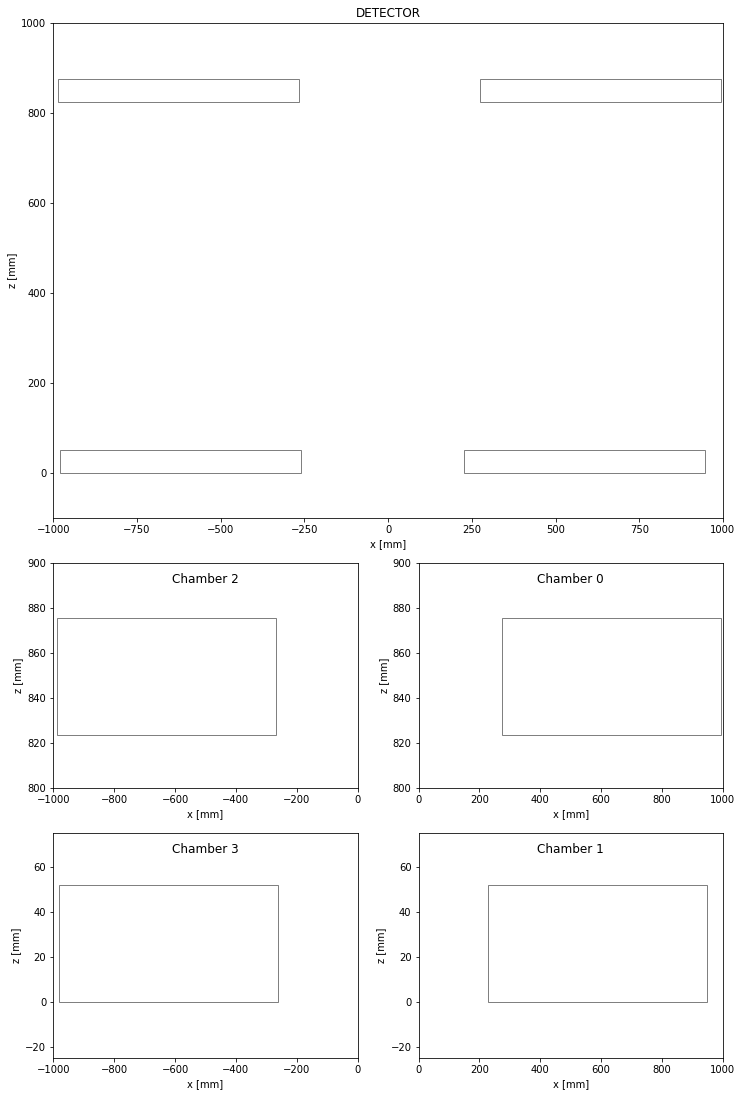

In [16]:
gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
plt.show()

# Plot events

- **Input**: Pandas `DataFrame` (1 event) + event number
- **Output**: `list`\[pyplot `Axes`\] (global image + 4 detectors zooms)

The input of the function is the Pandas `DataFrame` made by the *Read Data* function, and the event number (this is due to the fact that, if the are no hits, the `DataFrame` is empty, and therefore we can't get the Event number from that). Five plots are given as output: one image of the whole detector, and one for each of the 4 chambers. In the images there will be the points of the hits tracked in the event (left/right positions must have different colors).

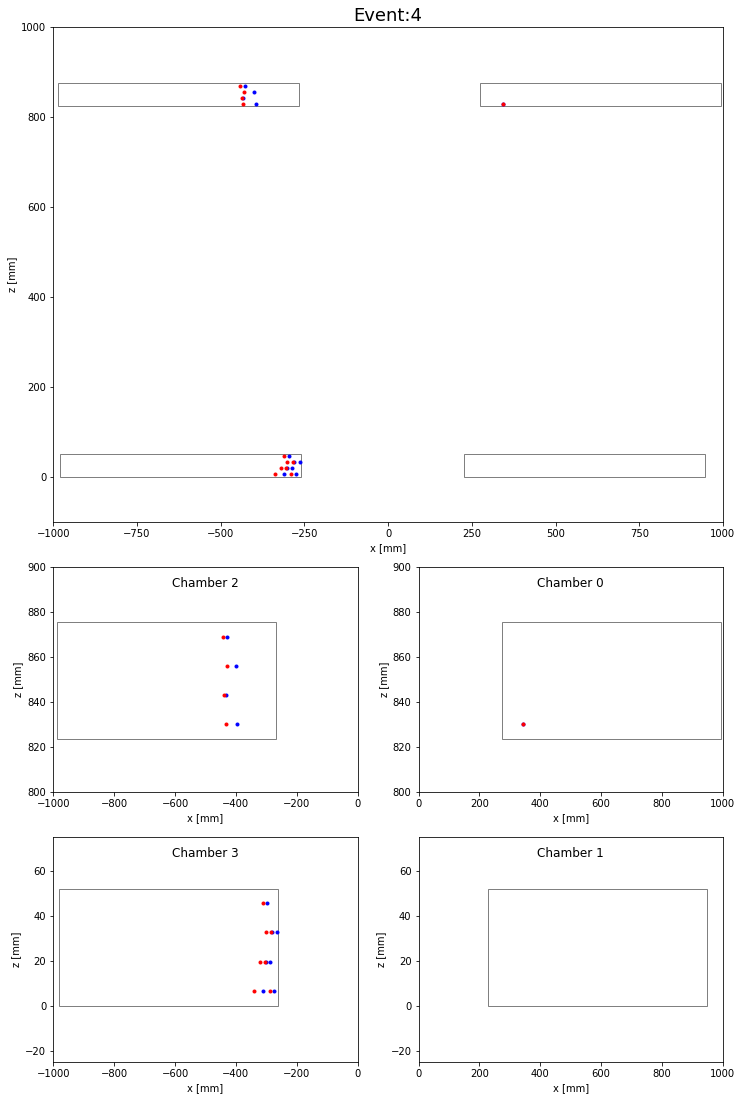

In [17]:
def plot_events(dataframe, evNumber):
    # get the EvNumber as argument, because, if the dataframe is empty,
    # I can't get it from data
    plots = plot_background()
    plots[0].set_title("Event:"+str(evNumber), {'size':'18'})
    if dataframe.empty == False:
        xL = dataframe["XL_global"]
        xR = dataframe["XR_global"]
        z  = dataframe["Z_global"]
        for index, image in enumerate(plots):     
            image.plot(xL, z, "bo", markersize=3)
            image.plot(xR, z, "ro", markersize=3)
    return plots

gridsize = (5, 2)
fig = plt.figure(figsize = (12, 24))
axes = plot_background()
axes = plot_events(ev, evNumber)
plt.show()

# [DRAFT] Select Events (Calibration)

- **Input**: Pandas `DataFrame`
- **Output**: True/False

The input of the function is the Pandas `DataFrame` made by the *Read Data* function. The output is a boolean value, which labels the good calibration events.

Good events requires at least 3 hits in different layers for each chamber, either in the left or in the right side of the detector.

In [19]:
def select_events(dataframe):
        
        #hits only in the left side
        if((dataframe['Chamber']<=1).all()):
            #compute number of different layers in each chamber
            n_layer_ch0 = dataframe[dataframe['Chamber']==0]['Layer'].nunique()
            n_layer_ch1 = dataframe[dataframe['Chamber']==1]['Layer'].nunique()
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch0>=3 and n_layer_ch1>=3):
                return True
            else:
                return False
            
        #hits only in the right side
        elif((dataframe['Chamber']>=2).all()):
            #compute number of different layers in each chamber
            n_layer_ch2 = dataframe[dataframe['Chamber']==2]['Layer'].nunique()
            n_layer_ch3 = dataframe[dataframe['Chamber']==3]['Layer'].nunique() 
            
            #require at least 3 different layers for each chamber
            if(n_layer_ch2>=3 and n_layer_ch3>=3):
                return True
            else:
                return False
        
        #hits in both left and right side
        else:
            return False
    
#print(select_events(ev))            
#print(ev)

    

False
    EvNumber  Hit  Chamber  Layer  XL_local  XR_local  Z_local   Time  \
0          4    0        0      1   650.100    651.90      6.5   15.8   
1          4    1        2      2   165.800    170.20     19.5   41.7   
2          4    2        2      4   160.600    175.40     45.5  137.5   
3          4    3        2      1   127.700    166.30      6.5  359.2   
4          4    4        2      3   131.800    162.20     32.5  282.5   
5          4    5        3      2    40.560     43.44     19.5   26.7   
6          4    6        3      1    13.950     28.05      6.5  130.8   
7          4    7        3      4    35.310     48.69     45.5  124.2   
8          4    8        3      3    18.530     23.47     32.5   45.8   
9          4    9        3      2    25.940     58.06     19.5  298.3   
10         4   10        3      3     2.871     39.13     32.5  336.7   
11         4   11        3      1    48.240     77.76      6.5  274.2   

    XL_global  XR_global  Z_global  
0     3

# Efficiency
